# PROJECT 2 - The DEBS Grand Challenge

This notebook demonstrates how to implement the 2015 DEBS Grand Challenge queries using PySpark.

## Overview

In this notebook, we will:

- **Data Ingestion & Cleansing**
  - Load a portion (e.g., 1 GB) of the NYC Taxi trip dataset.
  - Remove invalid rows (e.g., null or zero coordinates, unknown driver IDs) and cast columns to appropriate types.

- **Grid Cell Computation**
  - Map each latitude/longitude coordinate to a cell ID.
  - For Query 1, use a 500 m grid (cell IDs range from `1.1` to `300.300`).
  - For Query 2, use a 250 m grid (cell IDs range from `1.1` to `600.600`).

- **Query 1: Frequent Routes**
  - **Part 1:** Compute the 10 most frequent routes in the last 30 minutes, where a route is identified by `(start_cell, end_cell)`.
  - **Part 2:** Update results only when the top‑10 changes, and output one row containing:
    - `pickup_datetime`
    - `dropoff_datetime`
    - `start_cell_id_n`
    - `end_cell_id_n`
    - `delay`

- **Query 2: Profitable Areas**
  - **Part 1:** Calculate profitability for each area as  
    `(median fare + tip in last 15 minutes) / number of empty taxis in last 30 minutes`.
  - **Part 2:** Report the 10 most profitable areas. If fewer than 10 exist, fill in `NULL` for missing cells. Output one row for each update that includes:
    - `pickup_datetime`
    - `dropoff_datetime`
    - `profitable_cell_id_n`
    - `empty_taxies_in_cell_id_n`
    - `median_profit_in_cell_id_n`
    - `profitability_of_cell_n`
    - `delay`

- **Streaming Setup & Output**
  - Use PySpark Structured Streaming with `foreachBatch` to process micro-batches.
  - Maintain global state to detect changes in top‑10 routes or profitable areas.
  - Write final results to a table or console for each batch, including the delay metric (system time minus ingest time).


In [1]:
%pip install pyspark kafka-python delta-spark

  Using cached kafka_python-2.1.4-py2.py3-none-any.whl.metadata (9.1 kB)
  Using cached delta_spark-3.3.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
Using cached kafka_python-2.1.4-py2.py3-none-any.whl (276 kB)
Using cached delta_spark-3.3.0-py3-none-any.whl (21 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing all the necessary libraries
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql.types import *
from pyspark.sql.functions import col, to_timestamp, year, month, dayofmonth, lit, udf, floor, concat, lit, window, desc, expr, current_timestamp
from datetime import timedelta, datetime
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from datetime import datetime

import os
import math
import time

In [3]:
builder = SparkSession.builder.appName("project2_debs_grand_challenge") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:2.4.0") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.local.dir", "./temp")
spark = configure_spark_with_delta_pip(builder).getOrCreate()

#### Load the data

In [4]:
columns = [
    "medallion", "hack_license", "pickup_datetime", "dropoff_datetime",
    "trip_time_in_secs", "trip_distance", "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude", "payment_type", "fare_amount",
    "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount"
]


df = (
    spark.read
        .option("header", "false")
        .option("inferSchema", True)
        .csv("data/sorted_data.csv")
)
df = df.toDF(*columns)
df.printSchema()

#Take 1GB of original data
df_sample = df.sample(withReplacement=False, fraction=0.1)

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- surcharge: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



#### Query 0: Data cleaninig and set up

In [5]:
#converting pickup and dropoff datetimes to to_timestamp
df_sample = df_sample.withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"), "yyyy-MM-dd HH:mm:ss")) \
                     .withColumn("dropoff_datetime", to_timestamp(col("dropoff_datetime"), "yyyy-MM-dd HH:mm:ss"))

#Removing null or 0.0 columns and unknown licenses or drivers
df_clean = df_sample.filter(
    (col("medallion").isNotNull()) & (col("medallion") != "0") & (col("medallion") != "UNKNOWN") &
    (col("hack_license").isNotNull()) & (col("hack_license") != "0") & (col("hack_license") != "UNKNOWN") &
    (col("pickup_datetime").isNotNull()) &
    (col("dropoff_datetime").isNotNull()) &
    (col("trip_time_in_secs").isNotNull()) & (col("trip_time_in_secs") != 0) &
    (col("trip_distance").isNotNull()) & (col("trip_distance") != 0) &
    (col("pickup_longitude").isNotNull()) & (col("pickup_longitude") != 0.0) &
    (col("pickup_latitude").isNotNull()) & (col("pickup_latitude") != 0.0) &
    (col("dropoff_longitude").isNotNull()) & (col("dropoff_longitude") != 0.0) &
    (col("dropoff_latitude").isNotNull()) & (col("dropoff_latitude") != 0.0) &
    (col("trip_distance").cast("float") > 0) &
    (col("fare_amount").cast("float") > 0)
)

# Convert relevant columns to appropriate data types for numerical computations
df_clean = df_clean.withColumn("trip_time_in_secs", col("trip_time_in_secs").cast("int")) \
                   .withColumn("trip_distance", col("trip_distance").cast("float")) \
                   .withColumn("fare_amount", col("fare_amount").cast("float")) \
                   .withColumn("surcharge", col("surcharge").cast("float")) \
                   .withColumn("mta_tax", col("mta_tax").cast("float")) \
                   .withColumn("tip_amount", col("tip_amount").cast("float")) \
                   .withColumn("tolls_amount", col("tolls_amount").cast("float"))

df_clean.show(5)

+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|
+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+
|DFBFA82ECA8F7059B...|CF8604E72D83840FB...|2013-01-01 00:02:00|2013-01-01 00:03:00|               60|         0.39|      -73.981544|      40.781475|       -73.979439|       40.784386|         CRD|        3.0|

In [6]:
# Build the Time Model
# Convert the pickup datetime to extract year, month, and day.
df_clean = df_clean.withColumn("pickup_year", year("pickup_datetime")) \
                   .withColumn("pickup_month", month("pickup_datetime")) \
                   .withColumn("pickup_day", dayofmonth("pickup_datetime"))

df_clean.show(5)

+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-----------+------------+----------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|pickup_year|pickup_month|pickup_day|
+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-----------+------------+----------+
|DFBFA82ECA8F7059B...|CF8604E72D83840FB...|2013-01-01 00:02:00|2013-01-01 00:03:00|               60

In [10]:
# Write Cleansed Data with File Partitioning (Parquet format)
output_path = "output/cleansed_taxi_data"
df_clean.write.partitionBy("pickup_year", "pickup_month", "pickup_day") \
    .format("parquet") \
    .mode("overwrite") \
    .save(output_path)

In [7]:
from math import cos, radians

In [8]:
def latlon_distance(latA, lonA, latB, lonB):        
    degree_km = 111.32
    
    lat_dist = abs(latB - latA) * degree_km
    lon_dist = abs(lonB - lonA) * (degree_km * cos(radians(latA)))

    return lat_dist, lon_dist

In [9]:
def move_point(latA, lonA, north_km=0.250, east_km=0.250):
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * cos(radians(latA))

    new_lat = latA + (north_km / km_per_deg_lat)
    new_lon = lonA + (east_km / km_per_deg_lon)

    return new_lat, new_lon

In [10]:
pRoot = [41.474937, -74.913585]
p0 = move_point(pRoot[0], pRoot[1], 0.250 , 0.250)
broadcast_center = spark.sparkContext.broadcast(p0)


In [11]:
def getCells(center, lat, lon, upTo=300):
    distLat, distLon = latlon_distance(center[0], center[1], lat, lon)
    if distLat == -1 or distLon == -1:
        return -1, -1

    cellLat, cellLon = int(distLat//0.5), int(distLon//0.5)

    if distLat > upTo or distLon > upTo:
        return -1, -1

    return cellLat, cellLon    

In [12]:
def getCellString(lat, lon):
    center = broadcast_center.value
    cellLat, cellLon = getCells(center, lat, lon)
    return f"{cellLat}_{cellLon}"

In [13]:
getCellUDF = F.udf(getCellString, StringType())

### Query 1: Frequent Routes

#### Part 1: Finding top 10 most frequent routes during the last 30 minutes.

In [14]:
df_routes = df_clean.withColumn(
    "start_cell",
    getCellUDF(col("pickup_latitude"),col("pickup_longitude"))
    
).withColumn(
    "end_cell",
    getCellUDF(col("dropoff_latitude"),col("dropoff_longitude"))
    
)

In [15]:
df_routes_cleaned = df_routes.filter((col("end_cell") != "-1_-1") & (col("start_cell") != "-1_-1"))

In [88]:
c = df_routes_cleaned.count()

In [89]:
d = df_routes.count()

In [54]:
d-c

54469

In [90]:
d,c,d-c

(16930330, 16875861, 54469)

In [16]:
df_frequent_routes_by_time_window = (
    df_routes_cleaned
        .groupBy(F.window("pickup_datetime", "30 minutes"), "start_cell", "end_cell").count()
        .withColumnRenamed("count", "Number_of_Rides")
        .withColumnRenamed("window", "Time_window")
) 
top10_routes_by_time_window = df_frequent_routes_by_time_window.orderBy(col("Number_of_Rides").desc()).limit(10)
top10_routes_by_time_window.show()

+--------------------+----------+--------+---------------+
|         Time_window|start_cell|end_cell|Number_of_Rides|
+--------------------+----------+--------+---------------+
|{2013-01-14 08:00...|   159_154| 159_151|             16|
|{2013-01-15 08:30...|   159_154| 159_151|             14|
|{2013-02-14 06:30...|   160_153| 159_154|             13|
|{2013-10-23 07:00...|   160_153| 160_155|             13|
|{2013-01-14 08:00...|   159_154| 160_151|             13|
|{2013-03-27 07:00...|   160_153| 160_155|             12|
|{2013-11-17 20:30...|   159_154| 158_156|             12|
|{2013-09-24 07:00...|   160_153| 160_155|             12|
|{2013-02-07 07:00...|   160_153| 160_155|             12|
|{2013-11-25 06:30...|   160_153| 159_154|             11|
+--------------------+----------+--------+---------------+



In [79]:
import matplotlib.pyplot as plt

top10_df = top10_routes_by_time_window.toPandas()
labels = top10_df["start_cell"] + " → " + top10_df["end_cell"]
values = top10_df["Number_of_Rides"]

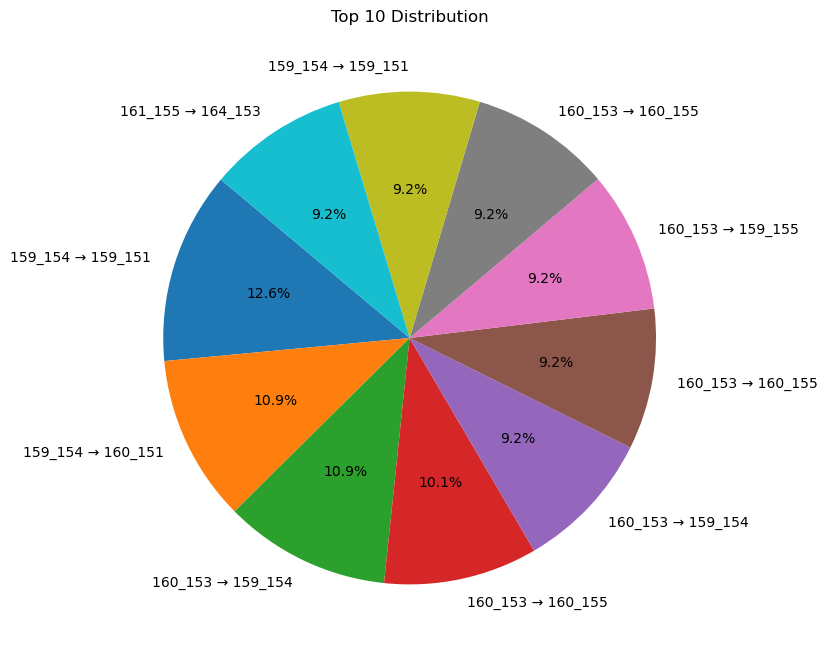

In [81]:
# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=140,)
plt.title("Top 10 Distribution")
plt.show()

In [93]:
print(top10_df.to_latex())

\begin{tabular}{llllr}
\toprule
 & Time_window & start_cell & end_cell & Number_of_Rides \\
\midrule
0 & Row(start=Timestamp('2013-01-15 09:00:00'), end=Timestamp('2013-01-15 09:30:00')) & 159_154 & 159_151 & 15 \\
1 & Row(start=Timestamp('2013-01-14 08:00:00'), end=Timestamp('2013-01-14 08:30:00')) & 159_154 & 160_151 & 13 \\
2 & Row(start=Timestamp('2013-01-15 06:30:00'), end=Timestamp('2013-01-15 07:00:00')) & 160_153 & 159_154 & 13 \\
3 & Row(start=Timestamp('2013-06-20 07:00:00'), end=Timestamp('2013-06-20 07:30:00')) & 160_153 & 160_155 & 12 \\
4 & Row(start=Timestamp('2013-03-07 06:30:00'), end=Timestamp('2013-03-07 07:00:00')) & 160_153 & 159_154 & 11 \\
5 & Row(start=Timestamp('2013-04-15 07:00:00'), end=Timestamp('2013-04-15 07:30:00')) & 160_153 & 160_155 & 11 \\
6 & Row(start=Timestamp('2013-05-07 06:30:00'), end=Timestamp('2013-05-07 07:00:00')) & 160_153 & 159_155 & 11 \\
7 & Row(start=Timestamp('2013-11-14 06:30:00'), end=Timestamp('2013-11-14 07:00:00')) & 160_153 & 160

#### Part 2:  Query results must be updated whenever any of the 10 most frequent routes change.


In [17]:
# Writing the cleansed data to a Delta table in a writable directory.
df_clean.write.format("delta").mode("overwrite").save("/tmp/delta/taxi_data")
df_stream = spark.readStream.format("delta").load("/tmp/delta/taxi_data")

In [18]:
#Read the Delta table in batch mode
check_df = spark.read.format("delta").load("/tmp/delta/taxi_data")
check_df.show(5)

In [12]:
# Define your grid constants for the 500m x 500m grid
grid_origin_lat = 41.474937
grid_origin_lon = -74.913585
delta_lat = 0.0045   # Approximate degrees for 500m in latitude
delta_lon = 0.0060   # Approximate degrees for 500m in longitude

# This is your foreachBatch function to process each micro-batch
def process_batch(batch_df, batch_id):
    # Skip empty batches
    if batch_df.rdd.isEmpty():
        return

    # Compute the 30-minute window based on the batch’s max dropoff
    max_dropoff = batch_df.agg({"dropoff_datetime": "max"}).collect()[0][0]
    if max_dropoff is None:
        return
    ref_time = max_dropoff - timedelta(minutes=30)

    # Compute grid cell IDs for pickup and dropoff using the 500m grid
    batch_df = batch_df.withColumn(
        "pickup_cell_east", floor((col("pickup_longitude") - lit(grid_origin_lon)) / lit(delta_lon)) + 1
    ).withColumn(
        "pickup_cell_south", floor((lit(grid_origin_lat) - col("pickup_latitude")) / lit(delta_lat)) + 1
    ).withColumn(
        "start_cell", concat(col("pickup_cell_east").cast("int"), lit("."), col("pickup_cell_south").cast("int"))
    )
    batch_df = batch_df.withColumn(
        "dropoff_cell_east", floor((col("dropoff_longitude") - lit(grid_origin_lon)) / lit(delta_lon)) + 1
    ).withColumn(
        "dropoff_cell_south", floor((lit(grid_origin_lat) - col("dropoff_latitude")) / lit(delta_lat)) + 1
    ).withColumn(
        "end_cell", concat(col("dropoff_cell_east").cast("int"), lit("."), col("dropoff_cell_south").cast("int"))
    )

    # Filter out trips that are out-of-bounds (only consider cells 1 to 300)
    batch_df = batch_df.filter(
        (col("pickup_cell_east").between(1, 300)) &
        (col("pickup_cell_south").between(1, 300)) &
        (col("dropoff_cell_east").between(1, 300)) &
        (col("dropoff_cell_south").between(1, 300))
    )

    # Filter for trips with dropoff_datetime >= ref_time (last 30 minutes)
    df_last30 = batch_df.filter(col("dropoff_datetime") >= F.lit(ref_time))
    print(f"Window filter: dropoff_datetime >= {ref_time}")
    print("df_last30 count =", df_last30.count())
    df_last30.show(5)

    # Aggregate routes and get top 10 most frequent
    df_frequent_routes = df_last30.groupBy("start_cell", "end_cell") \
        .count() \
        .withColumnRenamed("count", "Number_of_Rides")
    top10_routes = df_frequent_routes.orderBy(col("Number_of_Rides").desc()).limit(10)
    top10_list = top10_routes.collect()

    # Determine a triggering event and compute delay
    # Choose the event with the maximum dropoff_datetime as the trigger
    trigger_row = batch_df.orderBy(col("dropoff_datetime").desc()).limit(1).collect()[0]
    trigger_pickup = trigger_row["pickup_datetime"]
    trigger_dropoff = trigger_row["dropoff_datetime"]
    ingest_time = trigger_row["ingest_time"]
    processing_time = datetime.now()
    delay = (processing_time - ingest_time).total_seconds()

    # Build the output row
    output_row = {
        "pickup_datetime": trigger_pickup,
        "dropoff_datetime": trigger_dropoff,
        "delay": delay
    }
    for i in range(10):
        if i < len(top10_list):
            route = top10_list[i]
            output_row[f"start_cell_id_{i+1}"] = route["start_cell"]
            output_row[f"end_cell_id_{i+1}"] = route["end_cell"]
        else:
            output_row[f"start_cell_id_{i+1}"] = None
            output_row[f"end_cell_id_{i+1}"] = None

    print(f"Update for batch {batch_id} :", output_row)
    
    # Define the output schema explicitly
    output_schema = StructType([
        StructField("pickup_datetime", TimestampType(), True),
        StructField("dropoff_datetime", TimestampType(), True),
        StructField("start_cell_id_1", StringType(), True),
        StructField("end_cell_id_1", StringType(), True),
        StructField("start_cell_id_2", StringType(), True),
        StructField("end_cell_id_2", StringType(), True),
        StructField("start_cell_id_3", StringType(), True),
        StructField("end_cell_id_3", StringType(), True),
        StructField("start_cell_id_4", StringType(), True),
        StructField("end_cell_id_4", StringType(), True),
        StructField("start_cell_id_5", StringType(), True),
        StructField("end_cell_id_5", StringType(), True),
        StructField("start_cell_id_6", StringType(), True),
        StructField("end_cell_id_6", StringType(), True),
        StructField("start_cell_id_7", StringType(), True),
        StructField("end_cell_id_7", StringType(), True),
        StructField("start_cell_id_8", StringType(), True),
        StructField("end_cell_id_8", StringType(), True),
        StructField("start_cell_id_9", StringType(), True),
        StructField("end_cell_id_9", StringType(), True),
        StructField("start_cell_id_10", StringType(), True),
        StructField("end_cell_id_10", StringType(), True),
        StructField("delay", DoubleType(), True)
    ])
    
    # Create the result DataFrame using the explicit schema
    result_df = spark.createDataFrame([output_row], schema=output_schema)
    
    # Write the result_df as a table (it will create the table if it doesn't exist)
    result_df.write.mode("append").saveAsTable("frequent_routes")
    
    # Optional: Show the result DataFrame
    result_df.show(truncate=False)

# Ensure that your streaming DataFrame has proper types and includes an ingest_time column
df_stream = df_stream.withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))
df_stream = df_stream.withColumn("dropoff_datetime", to_timestamp(col("dropoff_datetime"), "yyyy-MM-dd HH:mm:ss"))
df_stream = df_stream.withColumn("ingest_time", current_timestamp())

# Use trigger(once=True) to process existing data exactly one time
query = (
    df_stream.writeStream
    .trigger(once=True)  #This means the query to run just once
    .foreachBatch(process_batch)
    .outputMode("append")
    .start()
)

query.awaitTermination()

In [13]:
#Display the result
spark.sql("SELECT * FROM frequent_routes").show()

+-------------------+-------------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+----------------+--------------+---------+
|    pickup_datetime|   dropoff_datetime|start_cell_id_1|end_cell_id_1|start_cell_id_2|end_cell_id_2|start_cell_id_3|end_cell_id_3|start_cell_id_4|end_cell_id_4|start_cell_id_5|end_cell_id_5|start_cell_id_6|end_cell_id_6|start_cell_id_7|end_cell_id_7|start_cell_id_8|end_cell_id_8|start_cell_id_9|end_cell_id_9|start_cell_id_10|end_cell_id_10|    delay|
+-------------------+-------------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+---------------+-------------+-----------

### Query 2: Profitable Areas

#### Part 1: Report only the 10 most profitable areas

In [14]:
# Grid constants for the 500m x 500m grid
grid_origin_lat = 41.474937
grid_origin_lon = -74.913585
delta_lat = 0.0045   # Approximate degrees for 500m in latitude
delta_lon = 0.0060   # Approximate degrees for 500m in longitude

def process_batch_query2(batch_df, batch_id):
    # Skip empty batches
    if batch_df.rdd.isEmpty():
        print(f"Batch {batch_id}: Empty batch.")
        return

    # Compute reference times based on the batch’s maximum dropoff_datetime
    max_dropoff = batch_df.agg({"dropoff_datetime": "max"}).collect()[0][0]
    if max_dropoff is None:
        print(f"Batch {batch_id}: max_dropoff is None.")
        return
    # For profit: consider trips ending in the last 15 minutes
    ref_time_profit = max_dropoff - timedelta(minutes=15)
    # For empty taxis: consider taxis whose last dropoff was within the last 30 minutes
    ref_time_empty = max_dropoff - timedelta(minutes=30)
    print(f"Batch {batch_id}: ref_time_profit = {ref_time_profit}, ref_time_empty = {ref_time_empty}")

    # Compute profit aggregate per area (using pickup location)
    profit_df = batch_df.filter(col("dropoff_datetime") >= F.lit(ref_time_profit)) \
        .withColumn("profit", col("fare_amount") + col("tip_amount")) \
        .withColumn(
            "pickup_cell_east",
            floor((col("pickup_longitude") - lit(grid_origin_lon)) / lit(delta_lon)) + 1
        ).withColumn(
            "pickup_cell_south",
            floor((lit(grid_origin_lat) - col("pickup_latitude")) / lit(delta_lat)) + 1
        ).withColumn(
            "pickup_cell",
            concat(col("pickup_cell_east").cast("int"), lit("."), col("pickup_cell_south").cast("int"))
        )
    profit_agg = profit_df.groupBy("pickup_cell") \
        .agg(F.expr("approx_percentile(profit, 0.5) as median_profit"))
    
    # Compute empty taxi aggregate per area (using dropoff location)
    w = Window.partitionBy("medallion").orderBy(col("dropoff_datetime").desc())
    last_dropoff_df = batch_df.withColumn("rn", F.row_number().over(w)) \
        .filter(col("rn") == 1)
    empty_df = last_dropoff_df.filter(col("dropoff_datetime") >= F.lit(ref_time_empty)) \
        .withColumn(
            "dropoff_cell_east",
            floor((col("dropoff_longitude") - lit(grid_origin_lon)) / lit(delta_lon)) + 1
        ).withColumn(
            "dropoff_cell_south",
            floor((lit(grid_origin_lat) - col("dropoff_latitude")) / lit(delta_lat)) + 1
        ).withColumn(
            "dropoff_cell",
            concat(col("dropoff_cell_east").cast("int"), lit("."), col("dropoff_cell_south").cast("int"))
        )
    empty_agg = empty_df.groupBy("dropoff_cell") \
        .agg(F.countDistinct("medallion").alias("empty_taxis"))
    
    # Join the two aggregates on the cell identifier.
    area_df = profit_agg.join(empty_agg, profit_agg.pickup_cell == empty_agg.dropoff_cell, "inner") \
        .select(profit_agg.pickup_cell.alias("cell_id"), "median_profit", "empty_taxis") \
        .filter(col("empty_taxis") > 0) \
        .withColumn("profitability", col("median_profit") / col("empty_taxis"))
    
    top10_areas = area_df.orderBy(col("profitability").desc()).limit(10)
    top10_list = top10_areas.collect()
    
    # Determine a triggering event and compute processing delay.
    trigger_row = batch_df.orderBy(col("dropoff_datetime").desc()).limit(1).collect()[0]
    trigger_pickup = trigger_row["pickup_datetime"]
    trigger_dropoff = trigger_row["dropoff_datetime"]
    # Use asDict() to safely check for "ingest_time"
    trigger_row_dict = trigger_row.asDict()
    if "ingest_time" in trigger_row_dict:
        ingest_time = trigger_row_dict["ingest_time"]
    else:
        ingest_time = trigger_dropoff  # fallback if missing
    processing_time = datetime.now()
    delay = (processing_time - ingest_time).total_seconds()
    
    # Build the output row.
    output_row = {
        "pickup_datetime": trigger_pickup,
        "dropoff_datetime": trigger_dropoff,
        "delay": delay
    }
    for i in range(10):
        if i < len(top10_list):
            area = top10_list[i]
            output_row[f"profitable_cell_id_{i+1}"] = area["cell_id"]
            output_row[f"empty_taxies_in_cell_id_{i+1}"] = str(area["empty_taxis"])
            output_row[f"median_profit_in_cell_id_{i+1}"] = area["median_profit"]
            output_row[f"profitability_of_cell_{i+1}"] = area["profitability"]
        else:
            output_row[f"profitable_cell_id_{i+1}"] = None
            output_row[f"empty_taxies_in_cell_id_{i+1}"] = None
            output_row[f"median_profit_in_cell_id_{i+1}"] = None
            output_row[f"profitability_of_cell_{i+1}"] = None

    print(f"Update for batch {batch_id}:", output_row)
    
    fields = [
        StructField("pickup_datetime", TimestampType(), True),
        StructField("dropoff_datetime", TimestampType(), True)
    ]
    for i in range(10):
        fields.extend([
            StructField(f"profitable_cell_id_{i+1}", StringType(), True),
            StructField(f"empty_taxies_in_cell_id_{i+1}", StringType(), True),
            StructField(f"median_profit_in_cell_id_{i+1}", DoubleType(), True),
            StructField(f"profitability_of_cell_{i+1}", DoubleType(), True)
        ])
    fields.append(StructField("delay", DoubleType(), True))
    output_schema = StructType(fields)
    
    result_df = spark.createDataFrame([output_row], schema=output_schema)
    # Write the result_df as a table
    result_df.write.mode("append").saveAsTable("most_profitable_areas_result")
    
    result_df.show(truncate=False)

# Ensure your streaming DataFrame has an ingest_time column.
df_stream = df_stream.withColumn("ingest_time", current_timestamp())

query2 = (
    df_stream.writeStream
    .trigger(once=True) 
    .foreachBatch(process_batch_query2)
    .outputMode("append")
    .start()
)

query2.awaitTermination()


In [15]:
spark.sql("SELECT * FROM most_profitable_areas_result").show()

+-------------------+-------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+---------------------+--------------------------+---------------------------+

#### Part2: Resulting stream of the query provide the 10 most profitable areas 

In [16]:
# Grid Constants for 250m x 250m grid
# The grid’s center of cell 1.1 remains at (41.474937, -74.913585).
# For 250m resolution, we use half the previous deltas:
new_delta_lat = 0.0045 / 2    # ≈0.00225
new_delta_lon = 0.0060 / 2    # ≈0.0030

# Define the foreachBatch function for Query 2 Part 2
def process_batch_query2_part2(batch_df, batch_id):
    # Skip empty batches
    if batch_df.rdd.isEmpty():
        print(f"Batch {batch_id}: Empty batch.")
        return

    # Compute reference times using batch’s maximum dropoff_datetime.
    max_dropoff = batch_df.agg({"dropoff_datetime": "max"}).collect()[0][0]
    if max_dropoff is None:
        print(f"Batch {batch_id}: max_dropoff is None.")
        return
    # For profit computation, consider trips that ended in the last 15 minutes.
    ref_time_profit = max_dropoff - timedelta(minutes=15)
    # For empty taxis, consider taxis whose last dropoff was within the last 30 minutes.
    ref_time_empty = max_dropoff - timedelta(minutes=30)
    print(f"Batch {batch_id}: ref_time_profit = {ref_time_profit}, ref_time_empty = {ref_time_empty}")

    # Compute profit aggregate per area (using pickup location).
    # Only consider trips with dropoff_datetime >= ref_time_profit.
    profit_df = batch_df.filter(col("dropoff_datetime") >= F.lit(ref_time_profit)) \
        .withColumn("profit", col("fare_amount") + col("tip_amount")) \
        .withColumn(
            "pickup_cell_east",
            floor((col("pickup_longitude") - lit(grid_origin_lon)) / lit(new_delta_lon)) + 1
        ).withColumn(
            "pickup_cell_south",
            floor((lit(grid_origin_lat) - col("pickup_latitude")) / lit(new_delta_lat)) + 1
        ).withColumn(
            "pickup_cell",
            concat(col("pickup_cell_east").cast("int"), lit("."), col("pickup_cell_south").cast("int"))
        )
    profit_agg = profit_df.groupBy("pickup_cell") \
        .agg(F.expr("approx_percentile(profit, 0.5) as median_profit"))
    
    # Compute empty taxi aggregate per area (using dropoff location).
    # For each taxi (medallion), take the latest dropoff event.
    w = Window.partitionBy("medallion").orderBy(col("dropoff_datetime").desc())
    last_dropoff_df = batch_df.withColumn("rn", F.row_number().over(w)) \
        .filter(col("rn") == 1)
    empty_df = last_dropoff_df.filter(col("dropoff_datetime") >= F.lit(ref_time_empty)) \
        .withColumn(
            "dropoff_cell_east",
            floor((col("dropoff_longitude") - lit(grid_origin_lon)) / lit(new_delta_lon)) + 1
        ).withColumn(
            "dropoff_cell_south",
            floor((lit(grid_origin_lat) - col("dropoff_latitude")) / lit(new_delta_lat)) + 1
        ).withColumn(
            "dropoff_cell",
            concat(col("dropoff_cell_east").cast("int"), lit("."), col("dropoff_cell_south").cast("int"))
        )
    empty_agg = empty_df.groupBy("dropoff_cell") \
        .agg(F.countDistinct("medallion").alias("empty_taxis"))
    
    # Join the aggregates on the cell identifier.
    # (We assume the area is defined by the same grid cell for pickup and dropoff.)
    area_df = profit_agg.join(empty_agg, profit_agg.pickup_cell == empty_agg.dropoff_cell, "inner") \
        .select(profit_agg.pickup_cell.alias("cell_id"), "median_profit", "empty_taxis") \
        .filter(col("empty_taxis") > 0) \
        .withColumn("profitability", col("median_profit") / col("empty_taxis"))
    
    # Get the top 10 areas by profitability.
    top10_areas = area_df.orderBy(col("profitability").desc()).limit(10)
    top10_list = top10_areas.collect()
    
    # Determine a triggering event and compute processing delay.
    # Choose the event with maximum dropoff_datetime as the trigger.
    trigger_row = batch_df.orderBy(col("dropoff_datetime").desc()).limit(1).collect()[0]
    trigger_pickup = trigger_row["pickup_datetime"]
    trigger_dropoff = trigger_row["dropoff_datetime"]
    # Convert the row to a dictionary for safe field access.
    trigger_row_dict = trigger_row.asDict()
    # Use ingest_time if available; otherwise, use trigger_dropoff as fallback.
    ingest_time = trigger_row_dict["ingest_time"] if "ingest_time" in trigger_row_dict else trigger_dropoff
    processing_time = datetime.now()
    delay = (processing_time - ingest_time).total_seconds()
    
    # Build the output row.
    # The required output columns are:
    # pickup_datetime, dropoff_datetime, then for each of the 10 areas:
    # profitable_cell_id_i, empty_taxies_in_cell_id_i, median_profit_in_cell_id_i, profitability_of_cell_i, and finally delay.
    output_row = {
        "pickup_datetime": trigger_pickup,
        "dropoff_datetime": trigger_dropoff,
        "delay": delay
    }
    for i in range(10):
        if i < len(top10_list):
            area = top10_list[i]
            output_row[f"profitable_cell_id_{i+1}"] = area["cell_id"]
            output_row[f"empty_taxies_in_cell_id_{i+1}"] = area["empty_taxis"]  # as integer
            output_row[f"median_profit_in_cell_id_{i+1}"] = area["median_profit"]
            output_row[f"profitability_of_cell_{i+1}"] = area["profitability"]
        else:
            output_row[f"profitable_cell_id_{i+1}"] = None
            output_row[f"empty_taxies_in_cell_id_{i+1}"] = None
            output_row[f"median_profit_in_cell_id_{i+1}"] = None
            output_row[f"profitability_of_cell_{i+1}"] = None

    print(f"Update for batch {batch_id}:", output_row)
    
    # Define the output schema.
    out_fields = [
        StructField("pickup_datetime", TimestampType(), True),
        StructField("dropoff_datetime", TimestampType(), True)
    ]
    for i in range(10):
        out_fields.extend([
            StructField(f"profitable_cell_id_{i+1}", StringType(), True),
            StructField(f"empty_taxies_in_cell_id_{i+1}", IntegerType(), True),
            StructField(f"median_profit_in_cell_id_{i+1}", DoubleType(), True),
            StructField(f"profitability_of_cell_{i+1}", DoubleType(), True)
        ])
    out_fields.append(StructField("delay", DoubleType(), True))
    output_schema = StructType(out_fields)
    
    result_df = spark.createDataFrame([output_row], schema=output_schema)
    # Write the result_df as a table
    result_df.write.mode("append").saveAsTable("profitable_areas_streaming_result")
    
    result_df.show(truncate=False)

# Ensure your streaming DataFrame (streaming_df) has an ingest_time column.
df_stream = df_stream.withColumn("ingest_time", current_timestamp())

# Set up the streaming query using foreachBatch.
query2_part2 = (
    df_stream.writeStream
    .trigger(once=True) 
    .foreachBatch(process_batch_query2_part2)
    .outputMode("append")
    .start()
)

query2_part2.awaitTermination()


In [17]:
spark.sql("SELECT * FROM profitable_areas_streaming_result").show()

+-------------------+-------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+--------------------+-------------------------+--------------------------+-----------------------+---------------------+--------------------------+---------------------------+